In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("US_Accidents_Dec20_updated_cleaned_imputed_data_prepared.csv")

In [3]:
X, y = df.drop("Severity", axis=1), df["Severity"]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# RFE using a decision tree

In [5]:
dtr_model = DecisionTreeClassifier(random_state=0)
dtr_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [6]:
rfe_selector = RFE(dtr_model, n_features_to_select=20)
rfe_selector = rfe_selector.fit(X_train, y_train)

In [7]:
X_train.columns[rfe_selector.support_]

Index(['Side', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Junction', 'Traffic_Signal', 'Month_Of_Year_sin',
       'Day_Of_Week_sin', 'Hour_Of_Day_sin', 'Month_Of_Year_cos',
       'Day_Of_Week_cos', 'Hour_Of_Day_cos', 'CA', 'IL', 'OR', 'Clear'],
      dtype='object')

In [8]:
pd.Series(rfe_selector.ranking_, index=X.columns).sort_values()[:30]

Side                  1
IL                    1
CA                    1
Hour_Of_Day_cos       1
Day_Of_Week_cos       1
Month_Of_Year_cos     1
Hour_Of_Day_sin       1
Day_Of_Week_sin       1
Month_Of_Year_sin     1
Traffic_Signal        1
Junction              1
OR                    1
Humidity(%)           1
Visibility(mi)        1
Wind_Speed(mph)       1
Precipitation(in)     1
Wind_Chill(F)         1
Clear                 1
Pressure(in)          1
Temperature(F)        1
Mostly Cloudy         2
CO                    3
Fair                  4
Calm                  5
AZ                    6
South                 7
Overcast              8
TX                    9
West                 10
Partly Cloudy        11
dtype: int64

# XGB Classifier

In [9]:
xgb_model = XGBClassifier(
    max_depth=10,
    n_estimators=100,
    importance_type="weight",
    n_jobs=-1,
    seed=0
)
xgb_model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    verbose=True
)

/mnt/HDD/anaconda3/envs/tf/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type='weight',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              seed=0, subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

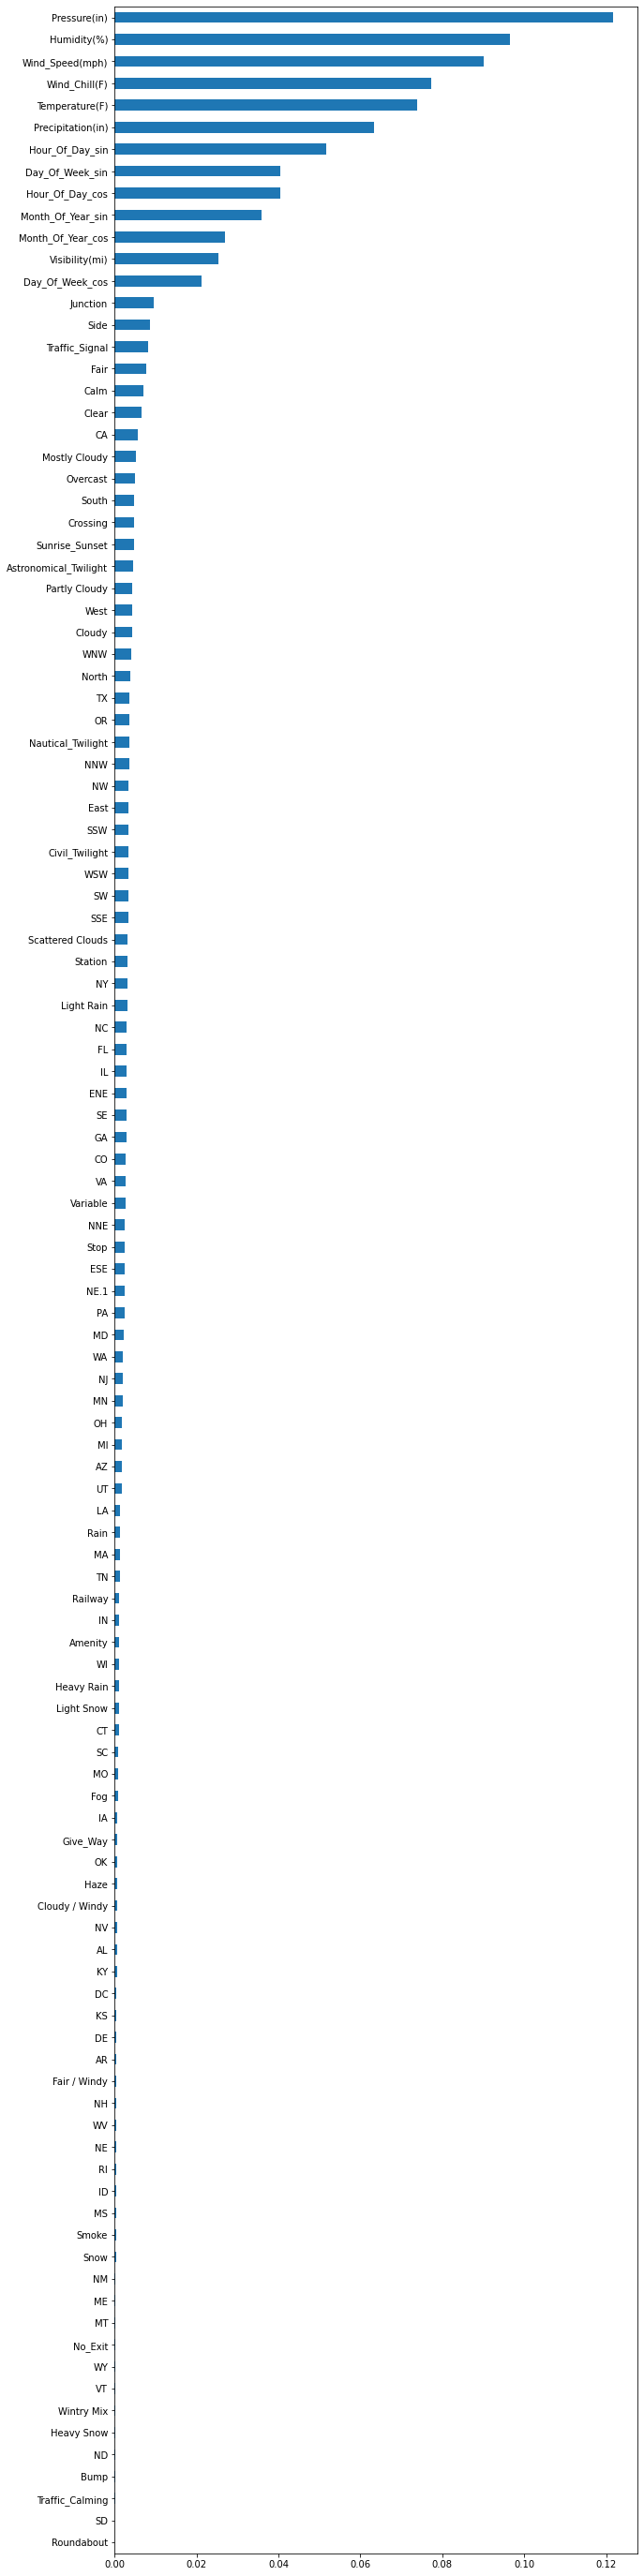

In [10]:
importances = xgb_model.feature_importances_
importances = pd.Series(importances, index=X.columns)
fig, ax = plt.subplots(figsize=(10, 50))
importances.sort_values().plot.barh(ax=ax)

In [11]:
importances.sort_values(ascending=False)[:20]

Pressure(in)         0.121629
Humidity(%)          0.096515
Wind_Speed(mph)      0.090021
Wind_Chill(F)        0.077246
Temperature(F)       0.073828
Precipitation(in)    0.063356
Hour_Of_Day_sin      0.051690
Day_Of_Week_sin      0.040517
Hour_Of_Day_cos      0.040382
Month_Of_Year_sin    0.035805
Month_Of_Year_cos    0.026946
Visibility(mi)       0.025377
Day_Of_Week_cos      0.021180
Junction             0.009576
Side                 0.008696
Traffic_Signal       0.008080
Fair                 0.007671
Calm                 0.006993
Clear                0.006696
CA                   0.005603
dtype: float32

# Extra trees classifier

In [12]:
ext_model = ExtraTreesClassifier(
    n_estimators=100,
    n_jobs=-1,
    random_state=0
)

ext_model.fit(X_train, y_train)

ExtraTreesClassifier(n_jobs=-1, random_state=0)

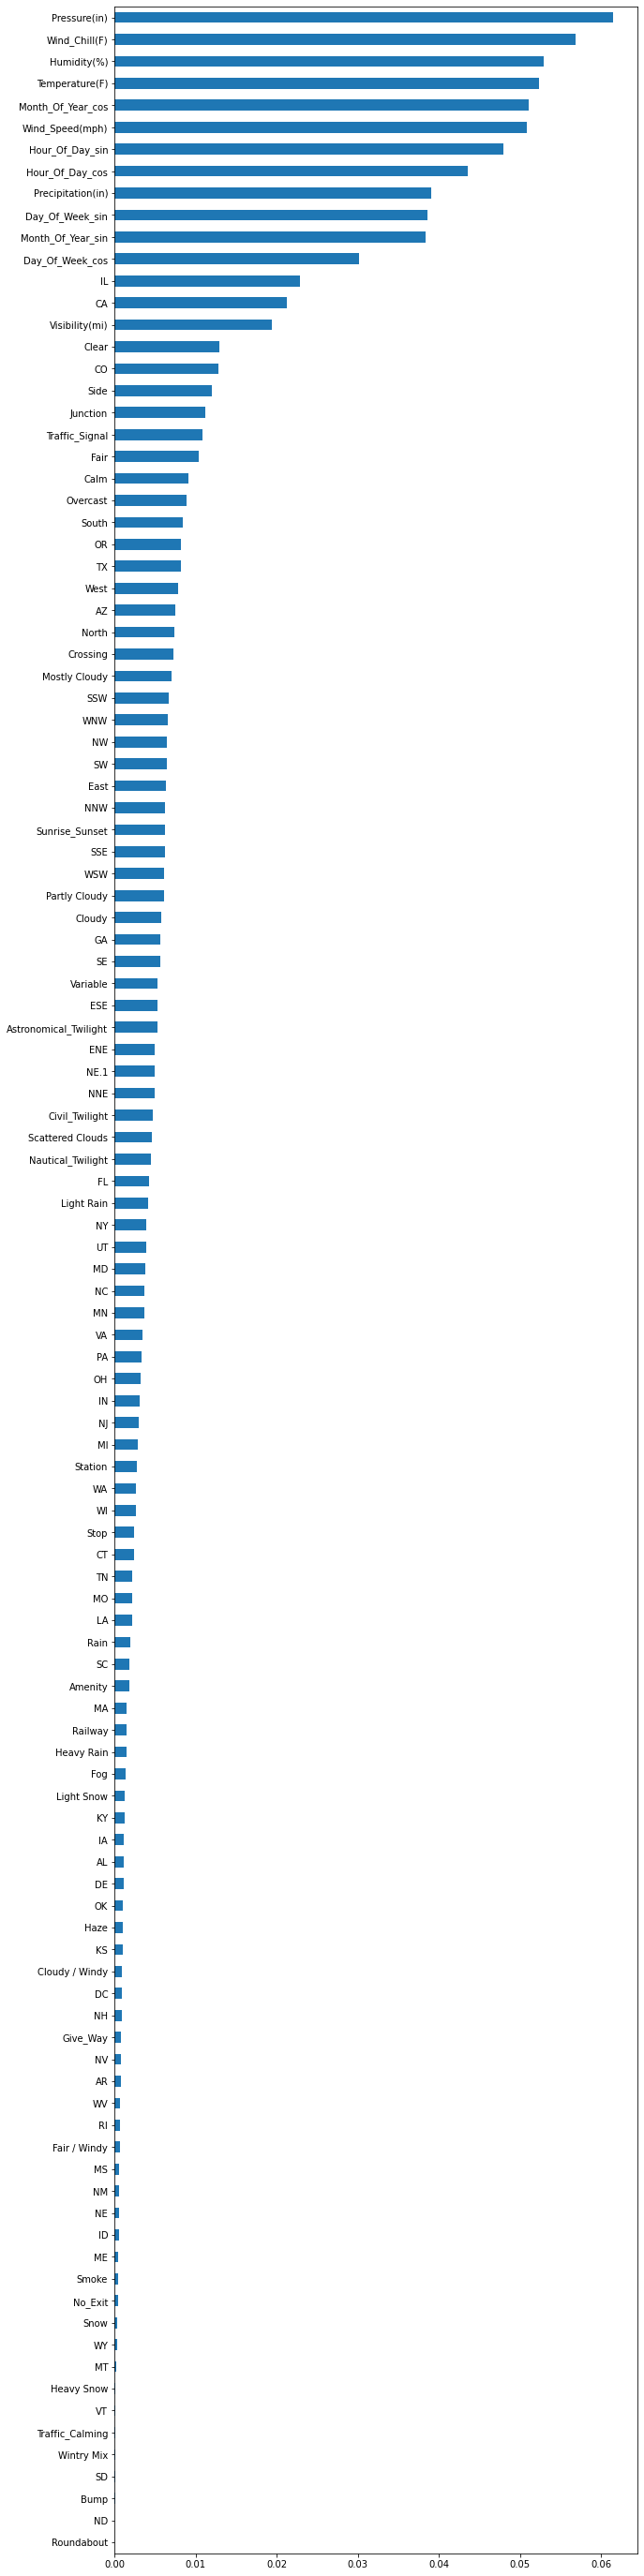

In [13]:
importances = ext_model.feature_importances_
importances = pd.Series(importances, index=X.columns)
fig, ax = plt.subplots(figsize=(10, 50))
importances.sort_values().plot.barh(ax=ax)

In [14]:
importances.sort_values(ascending=False)[:20]

Pressure(in)         0.061465
Wind_Chill(F)        0.056841
Humidity(%)          0.052989
Temperature(F)       0.052375
Month_Of_Year_cos    0.051059
Wind_Speed(mph)      0.050857
Hour_Of_Day_sin      0.047947
Hour_Of_Day_cos      0.043578
Precipitation(in)    0.039086
Day_Of_Week_sin      0.038562
Month_Of_Year_sin    0.038409
Day_Of_Week_cos      0.030113
IL                   0.022917
CA                   0.021284
Visibility(mi)       0.019448
Clear                0.012981
CO                   0.012847
Side                 0.011983
Junction             0.011234
Traffic_Signal       0.010854
dtype: float64

# Select K best

In [15]:
skb = SelectKBest(f_classif, k=20)
skb.fit(X_train, y_train)

SelectKBest(k=20)

In [16]:
X_train.columns[skb.get_support()]

Index(['Temperature(F)', 'Wind_Chill(F)', 'Pressure(in)', 'Wind_Speed(mph)',
       'Crossing', 'Traffic_Signal', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight', 'Month_Of_Year_sin', 'Month_Of_Year_cos', 'AZ',
       'CA', 'CO', 'GA', 'IL', 'TX', 'Clear', 'Fair', 'Overcast'],
      dtype='object')

In [17]:
skb = SelectKBest(mutual_info_classif, k=20)
skb.fit(X_train, y_train)

SelectKBest(k=20, score_func=<function mutual_info_classif at 0x7ff4d5273d30>)

In [18]:
X_train.columns[skb.get_support()]

Index(['Side', 'Temperature(F)', 'Wind_Chill(F)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)',
       'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight', 'Month_Of_Year_sin', 'Day_Of_Week_sin',
       'Month_Of_Year_cos', 'Day_Of_Week_cos', 'Hour_Of_Day_cos', 'CA', 'IL',
       'Clear', 'Fair'],
      dtype='object')